# Notebook 13: Hubs and Authorities
***

In this notebook we'll see the HITS algorithm in action, and examine a crude approach to generating graphs stochastically. We will also confirm what we saw in the lecture, which is that the hub and the authority scores are the principle eigenvalues of some forms of the link matrix describing the graph.

We'll need numpy for this notebook, so let's load it.

In [3]:
import numpy as np

<br>

### Exercise 0: Following along with lecture is cool!

From the lecture example, here is out graph:

<img width=200px src="http://www.cs.colorado.edu/~anwo7157/home/resources/hubsauthorities1.png">

And the associated link matrix:

In [9]:
L = np.array([[0,1,1,1,0],
              [1,0,0,1,0],
              [0,0,0,0,1],
              [0,1,1,0,0],
              [0,0,0,0,0]])
print(L, type(L))

[[0 1 1 1 0]
 [1 0 0 1 0]
 [0 0 0 0 1]
 [0 1 1 0 0]
 [0 0 0 0 0]] <class 'numpy.ndarray'>


Since we are using max-component = 1 normalization, we can initialize our hub and authority scores as all 1s:

In [7]:
n = L.shape[0]
hub = np.ones(n)
aut = np.ones(n)
print(aut, hub)

[1. 1. 1. 1. 1.] [1. 1. 1. 1. 1.]


In the first step in the first iteration of the HITS algorithm, we update the authority scores as $a^{(1)} = L^T h^{(0)}$, then normalize $a^{(1)}$ so its largest component is equal to 1:

In [8]:
# step forward:
aut = np.matmul(np.transpose(L), hub)
print(aut)
# normalize:
aut = aut/np.max(aut)
print(aut)

[1. 2. 2. 2. 1.]
[0.5 1.  1.  1.  0.5]


But hold on a second! Do you really want to keep transposing the $L$ matrix each iteration? That's for *suckers*. So let's save that in memory and never transpose it again.

In [28]:
LT = np.transpose(L)

Phew. We can now finish off the rest of the first iteration by updating and normalizing the hub scores as $h^{(1)} = L a^{(1)}$.

In [31]:
# step forward:
hub = np.matmul(L, aut)
hub = hub/np.max(hub)

Check that what we computed matches the by-hand calculation from lecture:

In [36]:
print("Authority scores: ", np.round(aut,4))
print("Hub scores: ", np.round(hub,4))

Authority scores:  [0.5 1.  1.  1.  0.5]
Hub scores:  [1.     0.5    0.1667 0.6667 0.    ]


Your mission, should you choose to accept it (spoiler alert: you should), is to iterate until the $L_2$ norm of both $h_{new} - h_{old}$ and $a_{new} - a_{old}$ are less than 0.001. (This means you will need to keep track of the old hub and authority scores within the iteration, for comparison against the new ones.)

For a sanity check, continue onward to Exercise 1!

In [48]:
def dist_L2(x,y):
    return np.sqrt(np.sum((x-y)**2))

n = L.shape[0]
hub = np.ones(n)
aut = np.ones(n)
tol = 0.001

hub_old = np.zeros(n) # initialize to track change in h and a
aut_old = np.zeros(n)
max_change = np.max([dist_L2(hub,hub_old), dist_L2(aut,aut_old)])

# TODO -- the rest of your HITS code (the main iteration)
#         goes down here!

In [49]:
# SOLUTION:

def dist_L2(x,y):
    return np.sqrt(np.sum((x-y)**2))

n = L.shape[0]
hub = np.ones(n)
aut = np.ones(n)
tol = 0.001

hub_old = np.zeros(n)
aut_old = np.zeros(n)
max_change = np.max([dist_L2(hub,hub_old), dist_L2(aut,aut_old)])

while max_change > tol:
    aut_old = aut
    hub_old = hub
    aut = np.matmul(LT, hub)
    aut = aut/np.max(aut)
    hub = np.matmul(L, aut)
    hub = hub/np.max(hub)
    max_change = np.max([dist_L2(hub,hub_old), dist_L2(aut,aut_old)])
    
print("Authority scores: ", np.round(aut,4))
print("Hub scores: ", np.round(hub,4))

Authority scores:  [0.2089 1.     1.     0.7915 0.    ]
Hub scores:  [1.     0.3584 0.     0.7165 0.    ]


<br>

### Exercise 1:  Hubbiness and Authorityness

In the lecture, we saw that the final converged values for the hub score ($h$) and the authority score ($a$) are the principle eigenvectors of the matrices $LL^T$ and $L^T L$, respectively. We can obtain the eigenvalues and eigenvectors of $LL^T$, for example, using the [numpy linalg.eig method](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html):

In [119]:
evals, evecs = np.linalg.eig(np.matmul(L,LT))

Just by having a look at the eigenvalues array, we notice that they are not necessarily sorted:

In [120]:
print(evals)

[4.79128785 0.20871215 2.         1.         0.        ]


The largest one is indeed first, so the principle eigenvector is the first column of `evecs`. But this may not be the case in general, so let's find the index of the maximal eigenvalue:

In [121]:
idx_princ = list(evals).index(np.max(evals))
print(idx_princ)

0


And use that to grab the principle eigenvector:

In [122]:
print(evecs[:,idx_princ])

[0.78045432 0.27960367 0.         0.55920734 0.        ]


*Hmm!* you say to yourself, *That doesn't match the hub score we found in Exercise 0. What have I done?!*

Don't even worry though! There is a good and simple explanation for it. Think about how we compute the hub score, and perhaps check the documentation for `linalg.eig` on how the eigenvector matrix is returned, and see if you can figure out the proper way to compare the two.

Then, compute the eigenvectors and eigenvalues associated with the $L^T L$ matrix and use them to check our work for the authority score. If you run into trouble, make sure that the first component of our eigenvectors is always nonnegative. If it's negative, you can flip the direction of a vector by multiplying by -1.

In [123]:
# SOLUTION:

# hub score:
print(evecs[:,idx_princ]/np.max(evecs[:,idx_princ]))

# authority score:
evals, evecs = np.linalg.eig(np.matmul(LT,L))
idx_princ = list(evals).index(np.max(evals))
print(evecs[:,idx_princ]/np.max(evecs[:,idx_princ]))

[1.         0.35825757 0.         0.71651514 0.        ]
[-inf -inf -inf -inf  nan]


/Users/tony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/tony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [124]:
# Crap! Something has gone terribly wrong. 
# It's because the first component is negative.
# So, we swap directions:
print(-evecs[:,idx_princ]/np.max(-evecs[:,idx_princ]))

[ 0.20871215  1.          1.          0.79128785 -0.        ]


<br>

### Exercise 2: Generating a random graph

The following code will generate a random graph on 6 nodes such that for each pair of nodes $(i,j)$, there is a connection from $i$ to $j$ with probability $p=0.33$.

In [15]:
np.random.seed(4022)
n = 6
p = 0.33
L1 = np.zeros((n,n))
for irow in range(n):
    for icol in range(n):
        L1[irow, icol] = np.random.choice([0,1], p=[1-p, p])
print(L1)

[[0. 1. 1. 0. 1. 1.]
 [1. 0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 1.]]


**[1]** On a piece of paper, draw this directed graph. Formulate a hypothesis about which node(s) will have the highest hub score, and which will have the highest authority score. What about the structure of the graph supports your hypotheses?

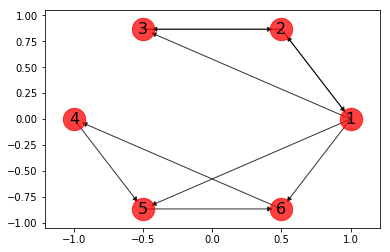

In [21]:
import networkx as nx
G=nx.DiGraph()
nodes=[i for i in range(1,7)]
G.add_nodes_from(nodes)
for irow in range(n):
    for icol in range(n):
        if L1[irow, icol]==1: G.add_edge(irow+1,icol+1)

#plot the graph
# np.random.seed(6) #graph plotting algorithm is random; this ensures same image each time
pos = nx.circular_layout(G) #algorithm that tries to "cluster" node plot locations
labels=dict(zip(range(1,7),range(1,7))); 
nx.draw_networkx_nodes(G, pos, node_size=500, alpha=.75); #node colors easy to see labels over
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.8); #draw edges
nx.draw_networkx_labels(G, pos, labels, font_size=16); #label vertices by index/number
# plt.axis("off");

**Solution:**

Node 1 has the highest out-degree, so that's a good candidate for highest hub score (since those are nodes that direct you to sources of information). Nodes 3 and 6 both have in-degree 3, so those are good candidates for the highest authority score (sources of information).

**[2]** Suppose we want to construct a graph so it is relatively more likely that a particular node has a high hub score. How could we modify the above code, without hard-coding any specifc connections? Similarly, what if we wanted to make it more likely that a node has a higher authority score? Implement your modification so that Node 2 is more likely to be a hub, and Node 6 is more likely to be an authority. Save the resulting link matrix as `L2`.

In [126]:
# SOLUTION:

np.random.seed(4022)
n = 6
p = 0.33
L2 = np.zeros((n,n))
ihub = 1 # row of the hub
iaut = 5 # col of the authority
p_inc = 0.75 # increase the probability of connections
for irow in range(n):
    for icol in range(n):
        if irow==ihub or icol==iaut:
            L2[irow, icol] = np.random.choice([0,1], p=[1-p_inc, p_inc])
        else:
            L2[irow, icol] = np.random.choice([0,1], p=[1-p, p])
print(L2)

[[0. 1. 1. 0. 1. 1.]
 [1. 1. 1. 0. 1. 1.]
 [0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 1.]]


<br>

### Exercise 3: HITS-ing that graph

Verify your hypotheses from Exercise 2 regarding the nodes that will be good hubs or authorities for your graphs. Use either the HITS algorithm (from Exercise 0) or the eigenvector approach (from Exercise 1). Did we succeed in our mission to make Node 2 a hub and Node 6 an authority?

In [131]:
# SOLUTION:

L1T = np.transpose(L1)

# hub score:
evals, evecs = np.linalg.eig(np.matmul(L1,L1T))
idx_princ = list(evals).index(np.max(evals))
evec_princ = evecs[:,idx_princ]
if evec_princ[0] < 0:
    evec_princ = -evec_princ
print(evec_princ/np.max(evec_princ))

# authority score:
evals, evecs = np.linalg.eig(np.matmul(L1T,L1))
idx_princ = list(evals).index(np.max(evals))
evec_princ = evecs[:,idx_princ]
if evec_princ[0] < 0:
    evec_princ = -evec_princ
print(evec_princ/np.max(evec_princ))

[1.         0.36936773 0.56073936 0.19137163 0.24788901 0.29532794]
[0.19137163 0.80862837 1.         0.15301117 0.61725675 0.79954991]


**Solution, Part 1:**

As we hypothesized, Node 1 has the highest hub score.

We hypothesized that Nodes 3 and 6 were likely to have the highest authority scores, but Node 2 actually has quite high authority score too. This can be attributed to its tight relationship with Nodes 1 and 3 (since the reputation of the pages that link to your page *and* that you link to affects your page's score).

In [133]:
# SOLUTION:

L2T = np.transpose(L2)

# hub score:
evals, evecs = np.linalg.eig(np.matmul(L2,L2T))
idx_princ = list(evals).index(np.max(evals))
evec_princ = evecs[:,idx_princ]
if evec_princ[0] < 0:
    evec_princ = -evec_princ
print(evec_princ/np.max(evec_princ))

# authority score:
evals, evecs = np.linalg.eig(np.matmul(L2T,L2))
idx_princ = list(evals).index(np.max(evals))
evec_princ = evecs[:,idx_princ]
if evec_princ[0] < 0:
    evec_princ = -evec_princ
print(evec_princ/np.max(evec_princ))

[0.90227684 1.         0.46211086 0.20603044 0.23413555 0.25949413]
[0.41737855 0.98684472 0.98684472 0.10830729 0.87996225 1.        ]


**Solution, Part 2:**

Yes, Node 2 is the hubbiest node, and Node 6 is the most authoritative authority. 